# <center> Binary Classification of Adults Dataset
## <center> Using a MLP
### <center> Saumya Rawat
    



In [139]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as utils
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.preprocessing import normalize

# Dataset introduction and loading

### The dataset consists of 45222 samples with 67 features. The dataset consists of 2 classes:
1. Income <= 50k
2. Income >= 50k

The dataset consists of ~75% points of Income <= 50k. The dimensions consist of features like age, workclass, education, marital-status, occupation, relationship, race etc. These variables have been converted into dummy/indicator variables.

The dataset is split with into test(25%) and train(75%) datasets. 

It is normalized along columns to account for different dimensions having different distributions. 

In [140]:
data = np.load("Adult/data.npy")
labels = np.load("Adult/labels.npy")

data = normalize(data, axis=0, norm='l1')

print("Number of samples: ", len(data))
print("Dimension of samples: ", len(data[0]))
n_dim = len(data[0])
print("Number of samples of class 1 (<=50k): ",(len(np.where(labels==1)[0])/len(data))*100)

# Train - test split
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size = 0.25, random_state = 0)

# Convert to torch tensor
#X_train = torch.stack([torch.Tensor(i) for i in X_train]) # transform to torch tensors
#y_train = torch.LongTensor(np.float64(y_train))

#X_test = torch.stack([torch.Tensor(i) for i in X_test]) # transform to torch tensors
#y_test = torch.LongTensor(np.float64(y_test))


Number of samples:  45222
Dimension of samples:  67
Number of samples of class 1 (<=50k):  75.21560302507629


In [141]:
# Data pre processing
class AdultDataset(Dataset):
    '''Adult Dataset'''
    def __init__(self, samples, labels, transform=None):
        """
        Args:
            transform (callable): Optional transform to apply to sample
        """
        self.X = samples
        self.Y = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        if self.transform:
            item = self.transform(item)
        return (item, label)

train_transform, test_transform = None, None
#normalize = transforms.Normalize(mean=list(img_mean),
#                                 std=list(img_std))
train_dataset = AdultDataset(X_train, y_train, train_transform)
test_dataset = AdultDataset(X_test, y_test, test_transform)



In [142]:
# CUDA PARAMETERS
if torch.cuda.is_available():
    cuda0 = torch.device('cuda:0')  # CUDA GPU 0

# The model

For this binary classification task, a simple MLP is chosen with a swish activation function. A sigmoid activation function was initially used and it yielded a 82.9% test accuracy. 


In [143]:
def swish(x):
    return (x*sigmoid(x))

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        # activation function for hidden layer
        #x = sigmoid(self.hidden(x)) -> Gave 82.9 %     
        x = swish(self.hidden(x))
        x = x.view(x.size(0), -1)
        #x = F.relu(self.hidden(x))
        x = self.out(x)
        return x

# Loss function and optimizer

Loss function used: Cross Entropy Loss Optimizer: 

An Adam optimizer with

    num_epochs = 100
    batch_size = 100
    learning_rate = 0.001

The SGD optimizer performed poorly for the given dataset.

In [144]:
net = Net(n_feature=67, n_hidden=20, n_output=2)     # define the network

if torch.cuda.is_available():
    print("Using CUDA")
    net.to(cuda0)

#loss function and optimizer
num_epochs = 150
batch_size = 100
learning_rate = 0.01
sigmoid = torch.nn.Sigmoid()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.05) -> Gave maximum 78% accuracy
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
criterion = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

print(net) # net architecture


Using CUDA
Net(
  (hidden): Linear(in_features=67, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)


# Training the model


In [145]:
plt.ion() # something about plotting
train_losses = []
train_accuracy = []


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

torch.set_grad_enabled(True)

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    t = 0

    for i, (samples, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            samples = samples.to(cuda0)
            labels = labels.to(cuda0)
        samples = Variable(samples.float())
        labels = Variable(labels.long())
        
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = net(samples)
        
        # LOSS
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # ACCURACY
        _, predicted = torch.max(outputs.data, 1)
        pred_y = predicted.data.cpu().numpy().squeeze()
        target_y = labels.cpu().data.numpy()
        train_acc += (float((pred_y == target_y).astype(int).sum()) / float(target_y.size))
        t+=1
    train_accuracy.append(train_acc/t)
    train_losses.append(train_loss/t)

    if (epoch) % 10 == 0:
        print ('Epoch : %d/%d, Loss: %.4f' %(epoch+1, num_epochs, (train_loss/t)))
        

Epoch : 1/150, Loss: 0.5606
Epoch : 11/150, Loss: 0.3922
Epoch : 21/150, Loss: 0.3707
Epoch : 31/150, Loss: 0.3645
Epoch : 41/150, Loss: 0.3631
Epoch : 51/150, Loss: 0.3628
Epoch : 61/150, Loss: 0.3621
Epoch : 71/150, Loss: 0.3619
Epoch : 81/150, Loss: 0.3613
Epoch : 91/150, Loss: 0.3641
Epoch : 101/150, Loss: 0.3590
Epoch : 111/150, Loss: 0.3621
Epoch : 121/150, Loss: 0.3603
Epoch : 131/150, Loss: 0.3619
Epoch : 141/150, Loss: 0.3596


# Testing the model

### The final accuracy is 83.0084 %


In [146]:
net.eval()
torch.no_grad()
test_losses = []
test_accuracy = []

for epoch in range(num_epochs):

    epoch_acc = 0
    epoch_loss = 0
    c = 0
    
    for samples, labels in test_loader:
        if torch.cuda.is_available():
            samples, labels = samples.to(cuda0), labels.to(cuda0)

        samples = Variable(samples.float())
        labels = Variable(labels.long())
        
        optimizer.zero_grad()
        outputs = net(samples)
        


        # LOSS
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
    
    
        # ACCURACY
        _, predicted = torch.max(outputs.data, 1)
        pred_y = predicted.data.cpu().numpy().squeeze()
        target_y = labels.cpu().data.numpy()
        epoch_acc += float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
        
        c+=1
    
    test_accuracy.append(epoch_acc/c)
    test_losses.append(epoch_loss/c)

print('Test Accuracy of the model on test images: %.4f %%' % (100 * (sum(test_accuracy) / num_epochs)))


Test Accuracy of the model on test images: 83.0084 %


Text(0.5, 0, 'epoch')

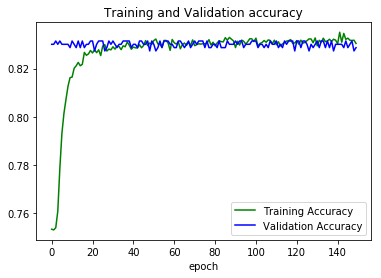

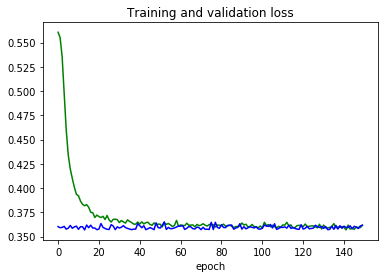

In [147]:
epochs = range(num_epochs)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, train_losses, 'g', label='Training Loss')
plt.plot(epochs, test_losses, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')



# Representative of the weight and biases


In [155]:
for k, v in net.state_dict().items():
    print("Layer {}".format(k))
    print(v)
    

Layer hidden.weight
tensor([[-80.1258, -16.4689, -44.4623,  ...,  10.1923,  -1.5453,   2.3294],
        [ 80.8661,  17.3223,  44.2950,  ..., -10.1787,   0.5774,  -2.5861],
        [ 81.1718,  18.3541,  45.2248,  ..., -12.0443,   1.1659,  -3.3578],
        ...,
        [ 81.5695,  18.9282,  45.8013,  ..., -13.1988,   1.6857,  -4.3031],
        [ 81.3526,  18.0799,  45.1275,  ..., -11.7931,   1.0287,  -3.2719],
        [-82.0758, -18.3151, -49.0600,  ...,  14.1016,  -2.6574,   3.9057]],
       device='cuda:0')
Layer hidden.bias
tensor([0.0804, 0.0592, 0.1951, 0.1529, 0.2438, 0.0924, 0.0540, 0.3255, 0.0440,
        0.0871, 0.1343, 0.0392, 0.1382, 0.2454, 0.2076, 0.3840, 0.0646, 0.2768,
        0.1607, 0.4024], device='cuda:0')
Layer out.weight
tensor([[-2.3282,  3.1939,  3.9988,  3.8741, -3.4189,  3.5063,  3.1491, -4.2108,
         -2.0398, -2.0391,  3.7973,  3.1506, -2.6622,  4.3063,  4.0833, -4.8412,
         -2.1752,  4.5958,  3.8002, -5.1414],
        [ 2.2425, -3.4290, -3.7157, -3.87

# Examples of datapoints that fail in the model



In [164]:
flag = 0
i = 0

while flag<5 and i<len(pred_y):
    if(pred_y[i]!=target_y[i]):
        
        print("For sample number ",i," :- Predicted: ",pred_y[i]," Class: ",target_y[i])
        flag+=1
    i+=1
    

For sample number  0  :- Predicted:  1  Class:  0
For sample number  1  :- Predicted:  1  Class:  0
